In [1]:
import numpy as np
import scipy as sp
from imp import reload

from scipy.stats import chi2,lognorm, norm, spearmanr, pearsonr, linregress
from scipy.optimize import curve_fit

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

bp={'color':'black','linewidth':2}
mp={'color':'#e50303','linewidth':2}
fp={'markersize':12,'color':'black'}

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

# Full Model

## Convergence

In [17]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\delta_{SC}^{pop}$', r'$\rho_C^{pop}$', r'$\delta_{CB}^{pop}$', r'$\rho_B^{pop}$', r'$\omega_{\rho_{S}}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\rho_C}$', r'$\omega_{\delta_{CB}}$', r'$\omega_{\rho_{B}}$',  r'$b_1$', r'$b_2$', r'$b_3$') 

n_pop_params=len(pop_params_names)  #number of parameters
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Model_Reduction/FullModel/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i]=aic
    data = np.genfromtxt('../data/Model_Reduction/FullModel/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2))    
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

likelihood = np.min(CA_logLikelihood)

CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <= 0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1

convergent_replicates = []
for i in range(n_rep):   
    if np.sum(Weights_sorted[:i]) > 0.95:
        CA_Pop_params[:,arg[i]] = None
        CA_Pop_params_se[:,arg[i]] = None
    else:
        convergent_replicates+=[i]
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

In [18]:
print('Optimal likelihood:', np.min(CA_logLikelihood))
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')

Optimal likelihood: 1761.142

Number of convergent runs according to w_AIC: 45

Convergent runs according to w_AIC:
 [34, 10, 6, 12, 29, 38, 21, 20, 14, 39, 3, 33, 35, 49, 8, 28, 27, 30, 19, 4, 42, 46, 0, 37, 17, 32, 41, 15, 13, 44, 23, 5, 11, 25, 2, 1, 45, 18, 36, 26, 22, 40, 7, 31, 48] 



/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


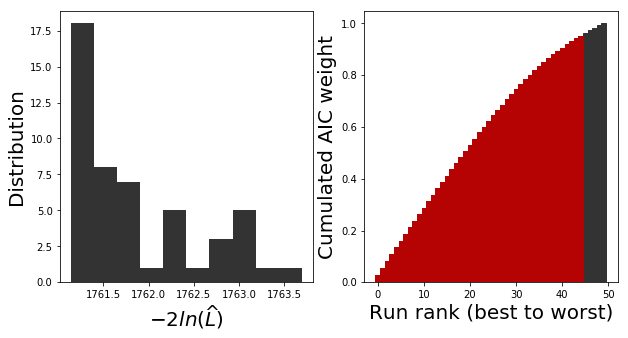

In [4]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, color='0.2')
yrange=ax[0].get_ylim()
ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('Cumulated AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_AIC.pdf', dpi='figure', bbox_inches='tight')   

## Population parameters

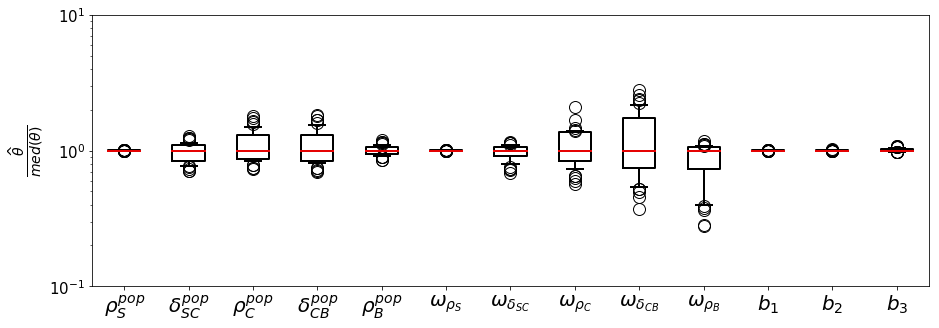

In [6]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1) , whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([1e-1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_PopulationParameters_Boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')     

## Correlation between the population parameters

In [7]:
unidentifiable_parameters = [1, 2, 3, 4, 6, 7, 8, 9]  #list of the unidentifiable parameters indeces (decided by hand)

n_unident_params = len(unidentifiable_parameters)

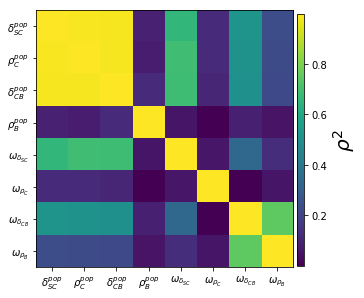

In [8]:
Unidentifiable_Pop_params = CA_Pop_params[:,mask][unidentifiable_parameters]
Correlations, Pvalues = spearmanr(Unidentifiable_Pop_params, axis=1, nan_policy='omit')

plt.rcParams['figure.figsize']=5,5
f, ax = plt.subplots()

im = plt.imshow(Correlations**2)
plt.xticks(range(len(unidentifiable_parameters)), np.array(pop_params_names)[unidentifiable_parameters])   
plt.yticks(range(len(unidentifiable_parameters)), np.array(pop_params_names)[unidentifiable_parameters])   

f.subplots_adjust(right=0.84)
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
axcb = f.colorbar(im, cax=cbar_ax)
axcb.set_label(r'$\rho^2$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_correlationsSpearman_UnidentParams.pdf', dpi='figure', bbox_inches='tight')

### $\delta_{CB}$ v/s $\rho_C$

	 $r^2 = 0.998$
	 1.3063227034192673 -0.5042429131620203


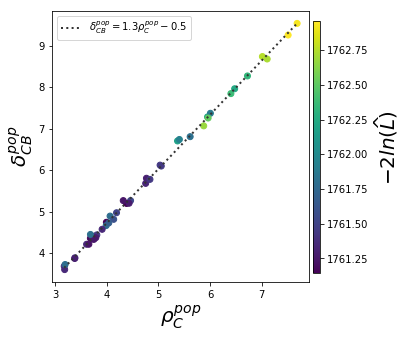

In [19]:
plt.rcParams['figure.figsize']=5,5
f, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = linregress(CA_Pop_params[2][mask], CA_Pop_params[3][mask])

xrange=(np.nanmin(CA_Pop_params[2]), np.nanmax(CA_Pop_params[2]))
dots=plt.scatter(CA_Pop_params[2],CA_Pop_params[3], c=CA_logLikelihood)
plt.plot(xrange, intercept + slope*np.array(xrange), ':', linewidth=2, c='0.2',label=r'$\delta_{CB}^{pop} = %.2g \rho_C^{pop} %.2g$'%(slope, intercept))   
plt.ylabel(r'$\delta_{CB}^{pop}$', fontsize=20)
plt.xlabel(r'$\rho_C^{pop}$', fontsize=20)
plt.legend(loc='upper left')
f.subplots_adjust(right=0.84)
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
axcb = f.colorbar(dots, cax=cbar_ax)
axcb.set_label(r'$-2ln(\widehat{L})$', fontsize=20)

print('\t', r'$r^2 = %.3g$'%r_value**2)
print('\t', slope, intercept)

savefig = True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_correlation_rhoCdeltaCB.pdf', dpi='figure', bbox_inches='tight')

#### $\delta_{SC}^{pop}$ v/s $\rho_C^{pop}$

In [20]:
def hyperb(rhoC, rhoC_min, deltaSC_min, epsilon, zeta):
    """Hyperbolic regression function for the correlation between deltaSC and rhoC."""
    
    deltaSC = deltaSC_min + epsilon*(rhoC - rhoC_min)**(-zeta)
    return(deltaSC)

low_bounds = np.array((0, 0, 0, 0))
up_bounds = np.array((np.nanmin(CA_Pop_params[1]), np.nanmin(CA_Pop_params[2]), 5, 5))

n_opt=1000
popt, pcov = curve_fit(hyperb, CA_Pop_params[2][mask], CA_Pop_params[1][mask], p0=low_bounds + (up_bounds - low_bounds)*np.random.rand(4), bounds=(low_bounds, up_bounds), check_finite=False, **{'maxfev':int(1e6)})
sqres = np.sum((hyperb(CA_Pop_params[2][mask], *popt) - CA_Pop_params[1][mask])**2)

for i in range(n_opt-1):
    popt2, pcov2 = curve_fit(hyperb, CA_Pop_params[2][mask], CA_Pop_params[1][mask], p0=low_bounds + (up_bounds - low_bounds)*np.random.rand(4), bounds=(low_bounds, up_bounds), check_finite=False, **{'maxfev':int(1e6)})
    sqres2 = np.sum((hyperb(CA_Pop_params[2][mask], *popt2) - CA_Pop_params[1][mask])**2)
    if sqres2 < sqres:
        popt = popt2
        pcov = pcov2
print('\t', popt)

	 [5.95744615e-15 1.41622693e-01 1.14577895e+00 1.24596124e+00]


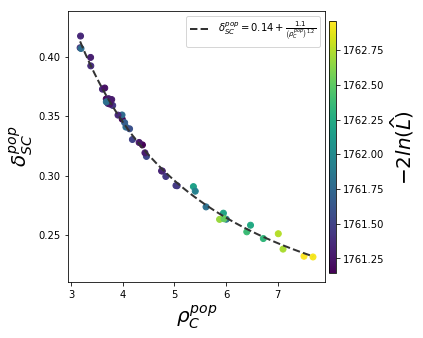

In [21]:
plt.rcParams['figure.figsize']=5,5
f, ax = plt.subplots()

xbounds = (np.nanmin(CA_Pop_params[2]), np.nanmax(CA_Pop_params[2]))
xrange=np.linspace(*xbounds)

dots=plt.scatter(CA_Pop_params[2],CA_Pop_params[1], c=CA_logLikelihood)
plt.plot(xrange, hyperb(xrange, *popt), '--', c='0.2', linewidth=2, label=r'$\delta_{SC}^{pop} = %.2g + \frac{%.2g}{\left( \rho_{C}^{pop}\right)^{%.2g}}$'%(popt[1], popt[2], popt[3]))    
plt.ylabel(r'$\delta_{SC}^{pop}$', fontsize=20)
plt.xlabel(r'$\rho_C^{pop}$', fontsize=20)
plt.legend()
f.subplots_adjust(right=0.84)
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
axcb = f.colorbar(dots, cax=cbar_ax)
axcb.set_label(r'$-2ln(\widehat{L})$', fontsize=20)


savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_correlation_rhoCdeltaSC.pdf', bbox_inches='tight', dpi='figure')

## Shrinkage

In [12]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\rho_C$', r'$\delta_{CB}$', r'$\rho_B$')

n_pop_params_variances = 5
n_pop_params_avg = 5

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Model_Reduction/FullModel/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,3,4,5))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

	Average shrinkage for each parameter:
 [0.02663902 0.31221445 0.76567297 0.63169669 0.38742359]


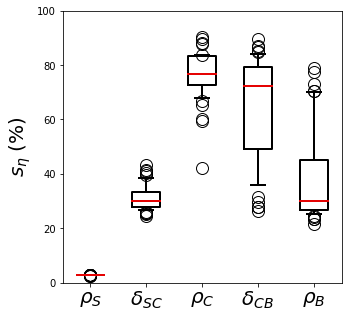

In [13]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,6), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('\tAverage shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Model_Reduction/FullModel/FullModel_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

# Reduced model without $\delta_{SC}$ and $\delta_{CB}$
## Convergence

In [5]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$\omega_{\rho_S}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\rho_C}$', r'$\omega_{\delta_{CB}}$', r'$\omega_{\rho_B}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCB/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCB/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)
    #here invalid_raise allows us to ignore the lines of the population parameter file where there is no s.e. (which are the lines corresponding the parameters that are not estimated)
    #invalid_raise = False will raise a warning instead of an error, which is why there are many warnings in the output of this cell
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

likelihood = np.min(CA_logLikelihood)
        
CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1
    
for i in range(imax,n_rep):   
    CA_Pop_params[:,arg[i]] = None
    CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:14: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)


In [7]:
print(("Optimal Likelihood: %.6g"%likelihood))
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')

Optimal Likelihood: 1761.09

Number of convergent runs according to w_AIC: 36

Convergent runs according to w_AIC:
 [48, 26, 29, 46, 28, 42, 11, 25, 41, 39, 5, 49, 0, 36, 19, 21, 40, 44, 16, 8, 17, 14, 30, 32, 10, 35, 27, 33, 3, 34, 38, 6, 1, 43, 45, 15] 



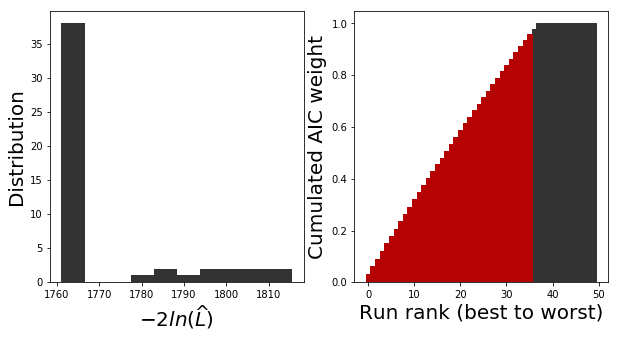

In [49]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

#for i in range(len(arg)):
#    ax[0].plot(i,CA_logLikelihood[arg[i]],'.',c='0.2')
#ax[0].plot(ax[0].get_xlim(),[threshold, threshold],':',linewidth=2,c='0.2',label='min(AIC)+10')
#ax[0].set_xlabel('Model rank (best to worst)',fontsize=20)
#ax[0].set_ylabel('AIC',fontsize=20)
#plt.legend(loc='upper left',fontsize=20)

ax[0].hist(CA_logLikelihood, color='0.2')
yrange=ax[0].get_ylim()
#ax[0].plot([threshold, threshold], yrange, '--', c='#b50303', linewidth=2)
ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

#ax[1].bar(np.arange(imax),np.sort(CA_w_AIC)[::-1][:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('Cumulated AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCB/ReducedModel_deltaSCdeltaCB_AIC.pdf', dpi='figure', bbox_inches='tight')   

## Population parameters

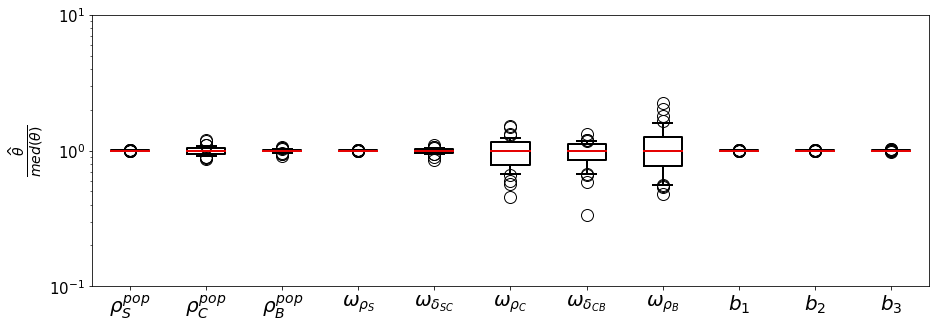

In [50]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)
#plt.ylabel(r'$s_{\eta}$', fontsize=20)
#plt.ylim(0,1)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCB/ReducedModel_deltaSCdeltaCB_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

## Shrinkage

In [12]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\rho_C$', r'$\delta_{CB}$', r'$\rho_B$')

n_pop_params_variances = 5
n_pop_params_avg = 3

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCB/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,4,5,6))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

	Average shrinkage for each parameter:
 [0.02732944 0.27879451 0.65948923 0.39634648 0.61917486]


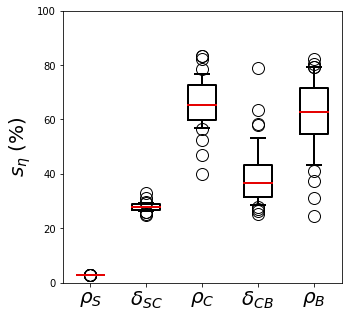

In [13]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,6), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('\tAverage shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCB/ReducedModel_deltaSCdeltaCB_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

# Reduced model without $\delta_{SC}$, $\delta_{CB}$ & $\omega_{\rho_C}$
## Convergence

In [10]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$\omega_{\rho_S}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\delta_{CB}}$', r'$\omega_{\rho_B}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)    
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]


CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1

for i in range(imax, n_rep):   
    CA_Pop_params[:,arg[i]] = None
    CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:14: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)


In [11]:
print('Optimal Likelihodd: %.6g'%np.min(CA_logLikelihood))
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')

Optimal Likelihodd: 1760.85

Number of convergent runs according to w_AIC: 36

Convergent runs according to w_AIC:
 [11, 41, 14, 6, 30, 45, 37, 35, 8, 40, 27, 29, 42, 12, 38, 39, 15, 48, 5, 46, 43, 34, 21, 17, 26, 33, 3, 10, 49, 16, 19, 32, 2, 28, 1, 36] 



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


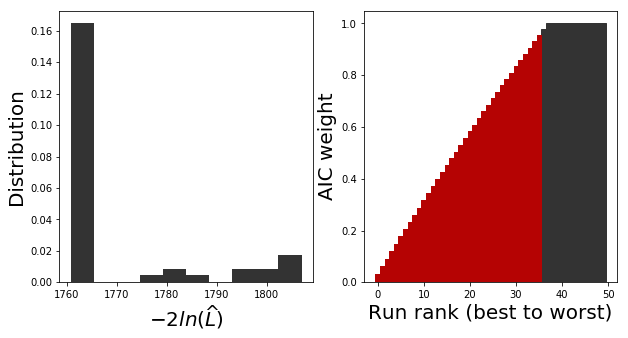

In [15]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, color='0.2', normed=True)
yrange=plt.ylim()
#ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

#ax[1].bar(np.arange(imax),np.sort(CA_w_AIC)[::-1][:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/ReducedModel_deltaSCdeltaCBomegarhoC_AIC.pdf', dpi='figure', bbox_inches='tight')   

## Population parameters

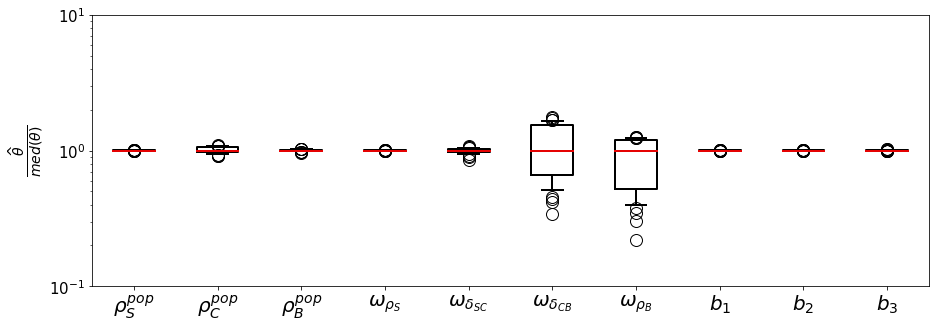

In [16]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/ReducedModel_deltaSCdeltaCBomegarhoC_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

## Shrinkage 

In [15]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\delta_{CB}$', r'$\rho_B$')

n_pop_params_avg=3
n_pop_params_variances=4

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,5,6))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    #print('\t', data)
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

	Average shrinkage for each parameter:
 [0.02692584 0.27583065 0.48741324 0.4362798 ]


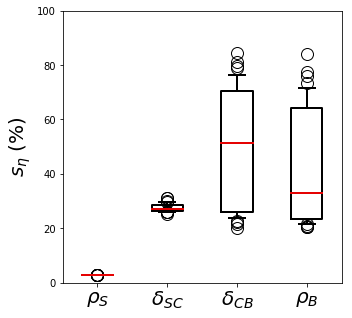

In [16]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,5), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('\tAverage shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoC/ReducedModel_deltaSCdeltaCBomegarhoC_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

# Reduced model without $\delta_{SC}$, $\delta_{CB}$ & $\omega_{\rho_B}$
## Convergence

In [12]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$\omega_{\rho_S}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\rho_C}$', r'$\omega_{\delta_{CB}}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)    
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_AIC=[]  #list of best models according to the AICc criterion
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1


for i in range(imax, n_rep):   
    CA_Pop_params[:,arg[i]] = None
    CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:14: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)


In [13]:
print('Optimal Likelihood: %.6g'%np.min(CA_logLikelihood))
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')


Optimal Likelihood: 1761.12

Number of convergent runs according to w_AIC: 22

Convergent runs according to w_AIC:
 [39, 41, 14, 12, 0, 23, 42, 46, 35, 28, 43, 27, 30, 38, 25, 15, 48, 19, 44, 32, 5, 26] 



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


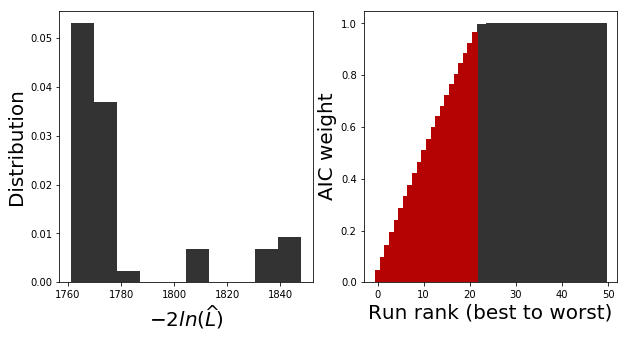

In [20]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, color='0.2', normed=True)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/ReducedModel_deltaSCdeltaCBomegarhoB_AIC.pdf', dpi='figure', bbox_inches='tight')   

## Population parameters 

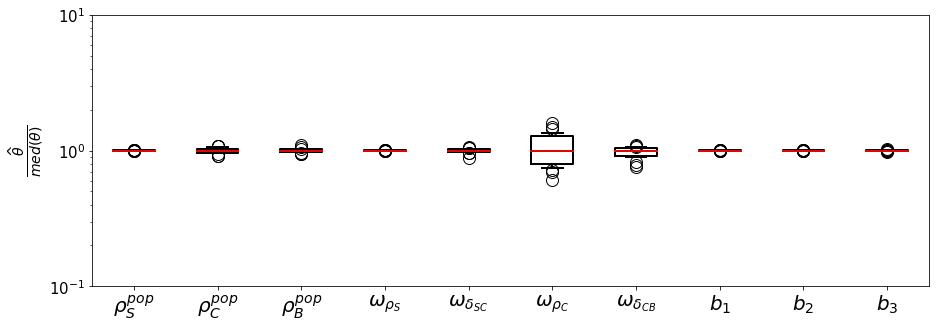

In [21]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/ReducedModel_deltaSCdeltaCBomegarhoB_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

## Shrinkage 

In [18]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\rho_C$', r'$\delta_{CB}$')

n_pop_params_avg=3
n_pop_params_variances=4

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,4,5))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    #print('\t', data)
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

	Average shrinkage for each parameter:
 [0.02797484 0.29143354 0.6342367  0.32124771]


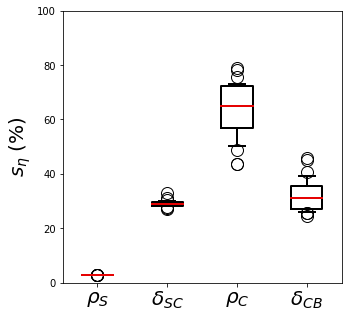

In [19]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,5), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('\tAverage shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoB/ReducedModel_deltaSCdeltaCBomegarhoB_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

# Model without $\delta_{sc}^{pop}$, $\delta_{CB}^{pop}$, $\omega_{\rho_C}$ & $\omega_{\rho_B}$
## Convergence

In [23]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$\omega_{\rho_S}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\delta_{CB}}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_pop_params_avg = 3
n_pop_params_variances = 3
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)    
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1
    
for i in range(imax, n_rep):   
    CA_Pop_params[:,arg[i]] = None
    CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)


In [15]:
print("Optimal likelihood: %.6g"%np.min(CA_logLikelihood))
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')

Optimal likelihood: 1760.99

Number of convergent runs according to w_AIC: 25

Convergent runs according to w_AIC:
 [43, 11, 0, 44, 31, 38, 15, 42, 35, 34, 26, 5, 46, 23, 39, 27, 48, 47, 28, 32, 25, 19, 4, 14, 41] 



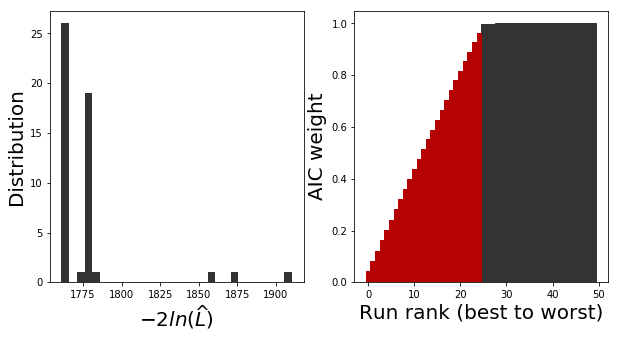

In [16]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, bins= 30, color='0.2')
yrange=plt.ylim()
#ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

#ax[1].bar(np.arange(imax),np.sort(CA_w_AIC)[::-1][:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB_AIC.pdf', dpi='figure', bbox_inches='tight')   

## Population parameters 

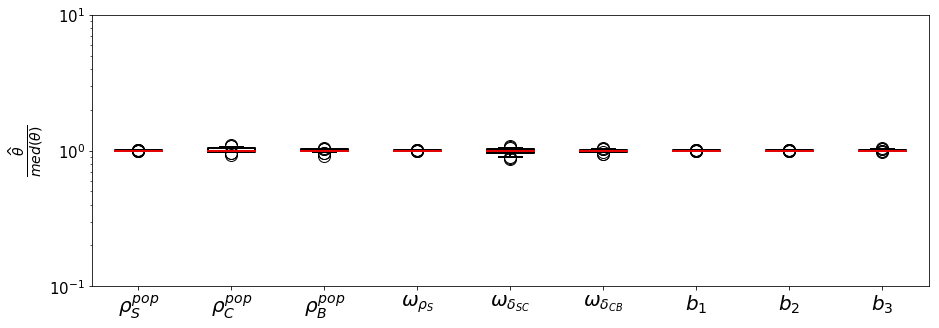

In [17]:
plt.rcParams['figure.figsize'] = 15, 5
f, ax = plt.subplots()

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

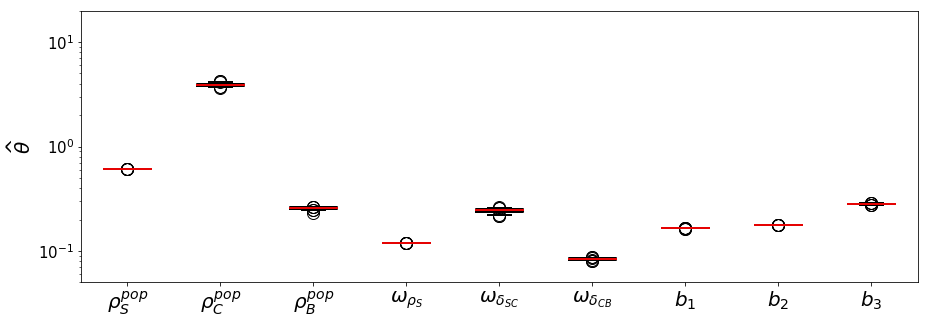

In [18]:
plt.rcParams['figure.figsize'] = 15, 5
f, ax = plt.subplots()

plt.boxplot(CA_Pop_params.T[mask.T], whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\widehat{\theta}$', fontsize=20)
plt.ylim(5e-2, 2e1)

savefig=True
if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB_PopulationParameters_boxplot.pdf', dpi='figure', bbox_inches='tight')   

## Shrinkage 

In [26]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\delta_{CB}$')

n_pop_params_variances = 3
n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,5))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    #print('\t', data)
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

Average shrinkage for each parameter:
 [0.02779944 0.28355541 0.21310011]


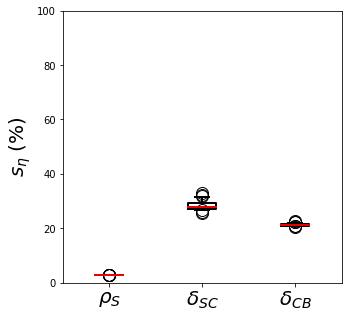

In [20]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,4), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)
xlim = plt.xlim()

print('Average shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True

if savefig:
    plt.savefig('../figures/Model_Reduction/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB/ReducedModel_deltaSCdeltaCBomegarhoComegarhoB_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

## Parameter values

In [27]:
def halflife(rho):
    return(24*np.log(2)/rho)

best_params = CA_Pop_params[:,arg[0]]

dist_rhoS = norm(loc=best_params[0], scale=best_params[n_pop_params_avg])
dist_deltaSC = lognorm(s=best_params[n_pop_params_avg+1], scale = hyperb(best_params[1], *popt))
dist_deltaCB = lognorm(s=best_params[n_pop_params_avg+2], scale = intercept + slope*best_params[1])

print('\tAverage population values in the best run (rhoSpop, deltaSCpop, rhoCpop, deltaCBpop, rhoBpop):')
print('\t%.4g\t%.4g\t%.4g\t%.4g\t%.4g'%(best_params[0], hyperb(best_params[1], *popt), best_params[1], intercept + slope*best_params[1], best_params[2])) 
print('\tCorresponding half-lives:')
print('\t%.4g\t%.4g\t%.4g\t%.4g\t%.4g\n'%(halflife(best_params[0]), halflife(hyperb(best_params[1], *popt)), halflife(best_params[1]), halflife(intercept + slope*best_params[1]), halflife(best_params[2]))) 

print('\tVariances in the best run (omegarhoS, omegadeltaSC, omegadeltaCB):')
print('\t%.4g\t%.4g\t%.4g\n'%(best_params[3], best_params[4], best_params[5]))

Dist = (dist_rhoS, dist_deltaSC, dist_deltaCB)
for i in range(n_pop_params_variances):
    dist = Dist[i]
    interval = dist.interval(0.95)
    print('\t%s confidence interval (lower bound, average, upper bound): %.5g \t %.5g \t %.5g'%(indiv_params_names[i], interval[0], dist.mean(), interval[1]))
    print('\tCorresponding Half-lives: %.5g \t %.5g \t %.5g'%(halflife(interval[0]), halflife(dist.mean()), halflife(interval[1])))


	Average population values in the best run (rhoSpop, deltaSCpop, rhoCpop, deltaCBpop, rhoBpop):
	0.613	0.3596	3.789	4.445	0.2569
	Corresponding half-lives:
	27.14	46.27	4.391	3.742	64.74

	Variances in the best run (omegarhoS, omegadeltaSC, omegadeltaCB):
	0.1186	0.2517	0.08603

	$\rho_S$ confidence interval (lower bound, average, upper bound): 0.38063 	 0.613 	 0.84537
	Corresponding Half-lives: 43.706 	 27.138 	 19.678
	$\delta_{SC}$ confidence interval (lower bound, average, upper bound): 0.21954 	 0.37113 	 0.58887
	Corresponding Half-lives: 75.775 	 44.825 	 28.25
	$\delta_{CB}$ confidence interval (lower bound, average, upper bound): 3.7553 	 4.4616 	 5.2615
	Corresponding Half-lives: 4.4299 	 3.7286 	 3.1617
